#Importing Required Packages

In [3]:
!pip install pandas_ta

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218909 sha256=216a241da2e057ebbec12c2d052a2abf4670d257698d206504fffc929c0d02a9
  Stored in directory: /root/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas_ta


In [4]:
import pandas_ta
import numpy as np
import matplotlib.pyplot as plt
import pandas_datareader.data as web
import datetime as dt
from statsmodels.regression.rolling import RollingOLS
import pandas as pd
import warnings
import yfinance as yf
warnings.filterwarnings("ignore")

sp500=pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]


In [ ]:
sp500

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott Laboratories,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
3,ABBV,AbbVie,Health Care,Biotechnology,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989
...,...,...,...,...,...,...,...,...
498,XYL,Xylem Inc.,Industrials,Industrial Machinery & Supplies & Components,"White Plains, New York",2011-11-01,1524472,2011
499,YUM,Yum! Brands,Consumer Discretionary,Restaurants,"Louisville, Kentucky",1997-10-06,1041061,1997
500,ZBRA,Zebra Technologies,Information Technology,Electronic Equipment & Instruments,"Lincolnshire, Illinois",2019-12-23,877212,1969
501,ZBH,Zimmer Biomet,Health Care,Health Care Equipment,"Warsaw, Indiana",2001-08-07,1136869,1927


In [ ]:
sp500['Symbol'] = sp500['Symbol'].str.replace('.','-') #because "." is not supported in yfinance

In [ ]:
print(sp500['Symbol'])

0       MMM
1       AOS
2       ABT
3      ABBV
4       ACN
       ... 
498     XYL
499     YUM
500    ZBRA
501     ZBH
502     ZTS
Name: Symbol, Length: 503, dtype: object


In [ ]:
end_date = '2023-09-27'
start_date = pd.to_datetime(end_date) - pd.DateOffset(365*8)

df = yf.download(sp500['Symbol'].tolist(), start=start_date, end=end_date).stack()

[**********************98%********************** ]  491 of 503 completedERROR:yfinance:Failed to get ticker 'LEN' reason: Expecting value: line 1 column 1 (char 0)
[**********************98%********************** ]  492 of 503 completedERROR:yfinance:Failed to get ticker 'EL' reason: Expecting value: line 1 column 1 (char 0)
[**********************98%********************** ]  493 of 503 completedERROR:yfinance:Failed to get ticker 'DIS' reason: Expecting value: line 1 column 1 (char 0)
[**********************98%********************** ]  494 of 503 completedERROR:yfinance:Failed to get ticker 'WTW' reason: Expecting value: line 1 column 1 (char 0)
[**********************98%********************** ]  495 of 503 completedERROR:yfinance:Failed to get ticker 'WELL' reason: Expecting value: line 1 column 1 (char 0)
[**********************99%***********************]  496 of 503 completedERROR:yfinance:Failed to get ticker 'EA' reason: Expecting value: line 1 column 1 (char 0)
[****************

In [ ]:
df.index.names = ['date','ticker']
df.columns = df.columns.str.lower()
df

Price               adj close       close        high         low        open  \
date       ticker                                                               
2015-09-29 A        31.375288   33.740002   34.060001   33.240002   33.360001   
           AAPL     24.595573   27.264999   28.377501   26.965000   28.207500   
           ABBV     35.718929   52.790001   54.189999   51.880001   53.099998   
           ABT      33.145817   39.500000   40.150002   39.029999   39.259998   
           ACGL     23.217773   24.416668   24.456667   24.100000   24.170000   
...                       ...         ...         ...         ...         ...   
2023-09-26 XYL      88.253998   89.519997   90.849998   89.500000   90.379997   
           YUM     121.017845  124.010002  124.739998  123.449997  124.239998   
           ZBH     111.287468  112.459999  117.110001  112.419998  116.769997   
           ZBRA    223.960007  223.960007  226.649994  222.580002  225.970001   
           ZTS     174.717117  176.869995  178.449997  176.270004  176.580002   

Price                   volume  
date       ticker               
2015-09-29 A         2252400.0  
           AAPL    293461600.0  
           ABBV     12842800.0  
           ABT      12287500.0  
           ACGL      1888800.0  
...                        ...  
2023-09-26 XYL       1322400.0  
           YUM       1500600.0  
           ZBH       3610500.0  
           ZBRA       355400.0  
           ZTS       1463200.0  

[956304 rows x 6 columns]

# Calculate features and technical indicators for each stock



*   Garman-klass Volatility

*   RSI

*   Bollinger Bands
*   ATR


*   MACD


*   Dollar Volume




In [ ]:
# Garman-klass Volatility
df['garman_klass_vol'] = ((np.log(df['high'])-np.log(df['low']))**2)/2 - (2*np.log(2)-1)*((np.log(df['adj close'])-np.log(df['open']))**2)

# RSI
df['rsi'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.rsi(close=x, length=20))

# Boiling Bands
df['bb_low'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,0])
df['bb_mid'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,1])
df['bb_high'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,2])


<Axes: xlabel='date'>

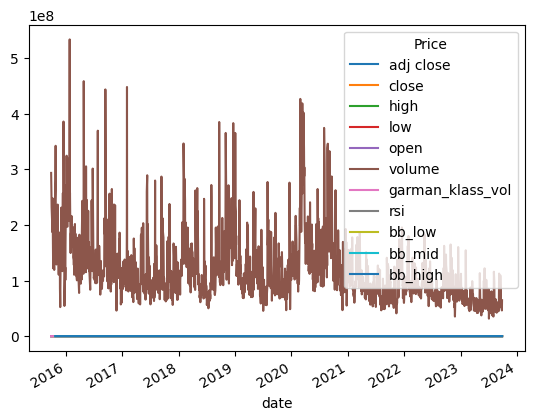

In [ ]:
# Checking Calculation
df.xs('AAPL', level=1).plot()

In [ ]:
# ATR Indicator

def compute_atr(stock_data):
    atr = pandas_ta.atr(high=stock_data['high'],
                        low=stock_data['low'],
                        close=stock_data['close'],
                        length=14)
    return atr.sub(atr.mean()).div(atr.std())

df['atr'] = df.groupby(level=1, group_keys=False).apply(compute_atr)


In [ ]:
# MACD
def compute_macd(close):
  macd = pandas_ta.macd(close=close, length=20).iloc[:,0]
  return macd.sub(macd.mean()).div(macd.std())
df['macd'] = df.groupby(level=1, group_keys=False)['adj close'].apply(compute_macd)

In [ ]:
# Dollar Volume
df['dollar_volume'] = (df['adj close']*df['volume'])/1e6

In [ ]:
df

Price               adj close       close        high         low        open  \
date       ticker                                                               
2015-09-29 A        31.375288   33.740002   34.060001   33.240002   33.360001   
           AAPL     24.595573   27.264999   28.377501   26.965000   28.207500   
           ABBV     35.718929   52.790001   54.189999   51.880001   53.099998   
           ABT      33.145817   39.500000   40.150002   39.029999   39.259998   
           ACGL     23.217773   24.416668   24.456667   24.100000   24.170000   
...                       ...         ...         ...         ...         ...   
2023-09-26 XYL      88.253998   89.519997   90.849998   89.500000   90.379997   
           YUM     121.017845  124.010002  124.739998  123.449997  124.239998   
           ZBH     111.287468  112.459999  117.110001  112.419998  116.769997   
           ZBRA    223.960007  223.960007  226.649994  222.580002  225.970001   
           ZTS     174.717117  176.869995  178.449997  176.270004  176.580002   

Price                   volume  garman_klass_vol        rsi    bb_low  \
date       ticker                                                       
2015-09-29 A         2252400.0         -0.001156        NaN       NaN   
           AAPL    293461600.0         -0.005949        NaN       NaN   
           ABBV     12842800.0         -0.059780        NaN       NaN   
           ABT      12287500.0         -0.010671        NaN       NaN   
           ACGL      1888800.0         -0.000516        NaN       NaN   
...                        ...               ...        ...       ...   
2023-09-26 XYL       1322400.0         -0.000107  26.146696  4.480372   
           YUM       1500600.0         -0.000213  36.057173  4.801976   
           ZBH       3610500.0         -0.000058  31.893206  4.743683   
           ZBRA       355400.0          0.000133  29.494977  5.400991   
           ZTS       1463200.0          0.000032  42.623480  5.151393   

Price                bb_mid   bb_high       atr      macd  dollar_volume  
date       ticker                                                         
2015-09-29 A            NaN       NaN       NaN       NaN      70.669699  
           AAPL         NaN       NaN       NaN       NaN    7217.856330  
           ABBV         NaN       NaN       NaN       NaN     458.731065  
           ABT          NaN       NaN       NaN       NaN     407.279224  
           ACGL         NaN       NaN       NaN       NaN      43.853730  
...                     ...       ...       ...       ...            ...  
2023-09-26 XYL     4.562291  4.644210  0.033800 -2.159189     116.707087  
           YUM     4.831939  4.861902  0.142547 -1.363697     181.599378  
           ZBH     4.783349  4.823015 -0.381708 -0.881067     401.803403  
           ZBRA    5.539167  5.677342 -0.057389 -1.600791      79.595386  
           ZTS     5.210205  5.269017  0.651515 -1.188278     255.646086  

[956304 rows x 14 columns]

# Aggregate to monthly level and filter top 150 most liquid stocks for each month.
* To reduce training time and experiment with features and strategies, we convert the buisness-daily data to month-end fz.

In [ ]:
df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume')

dollar_volume
date       ticker               
2015-09-30 A           75.969230
           AAPL      6915.990344
           ABBV       448.332236
           ABT        385.050801
           ACGL        76.237983
...                          ...
2023-09-30 PLTR       651.345225
           ABNB      1633.500725
           CEG        195.997266
           GEHC       212.127120
           KVUE       658.601592

[46102 rows x 1 columns]

In [ ]:
last_cols = [c for c in df.columns.unique(0) if c not in ['dollar_volume', 'volume', 'open',
                                                          'high', 'low', 'close']]

# df.unstack()[last_cols].resample('M').last().stack().stack('ticker')

In [ ]:
data = (pd.concat([df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume'),
                   df.unstack()[last_cols].resample('M').last().stack('ticker')],
                  axis=1)).dropna()


In [ ]:
data

dollar_volume   adj close  garman_klass_vol        rsi  \
date       ticker                                                           
2015-11-30 A          135.525165   38.888992         -0.002190  73.421500   
           AAPL      4014.914394   26.793610         -0.003473  55.537338   
           ABBV       331.841263   39.708752         -0.064880  49.376889   
           ABT        209.554460   37.912804         -0.012576  56.962531   
           ACGL        28.174423   22.970539         -0.001121  35.682522   
...                          ...         ...               ...        ...   
2023-09-30 PLTR       651.345225   13.960000          0.000214  41.544692   
           ABNB      1633.500725  132.279999          0.000213  44.494127   
           CEG        195.997266  107.492867          0.000035  55.245472   
           GEHC       212.127120   66.083885          0.000184  40.922349   
           KVUE       658.601592   19.642262         -0.000697  35.706315   

                     bb_low    bb_mid   bb_high       atr      macd  
date       ticker                                                    
2015-11-30 A       3.542646  3.615088  3.687530 -1.033887  0.567158  
           AAPL    3.279507  3.322815  3.366124 -0.967900 -0.142789  
           ABBV    3.710011  3.758240  3.806469 -0.526809  0.145677  
           ABT     3.646322  3.668170  3.690018 -1.064842  0.335557  
           ACGL    3.177974  3.195190  3.212406 -1.155694 -0.550166  
...                     ...       ...       ...       ...       ...  
2023-09-30 PLTR    2.701939  2.779743  2.857548 -0.426167 -0.433581  
           ABNB    4.857047  4.940924  5.024801 -1.006939 -0.037854  
           CEG     4.648751  4.688923  4.729095 -0.436215  0.366877  
           GEHC    4.154746  4.212281  4.269817 -0.893478 -1.116462  
           KVUE    2.996823  3.071707  3.146590 -0.899746 -1.435620  

[45153 rows x 9 columns]

* Calculate 5-year rolling average of dollar volume for each stocks before filtering.


In [ ]:
data['dollar_volume'] = (data.loc[:, 'dollar_volume'].unstack('ticker').rolling(5*12, min_periods=12).mean().stack())
data['dollar_vol_rank'] = (data.groupby('date')['dollar_volume'].rank(ascending=False))


In [ ]:
data = data[data['dollar_vol_rank']<150].drop(['dollar_volume', 'dollar_vol_rank'], axis=1)


In [ ]:
data

adj close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                      
2016-10-31 AAPL     26.153395         -0.002611  49.891079  3.292064   
           ABBV     39.562847         -0.051416  27.477651  3.736752   
           ABT      33.952469         -0.008608  38.008888  3.544926   
           ACN     102.699394         -0.005388  53.823736  4.628986   
           ADBE    107.510002          0.000059  53.668389  4.679513   
...                       ...               ...        ...       ...   
2023-09-30 MRNA     98.120003          0.000146  38.747314  4.582514   
           UBER     44.270000          0.000441  45.005268  3.806654   
           CRWD    160.479996          0.000144  51.534803  5.026187   
           PLTR     13.960000          0.000214  41.544692  2.701939   
           ABNB    132.279999          0.000213  44.494127  4.857047   

                     bb_mid   bb_high       atr      macd  
date       ticker                                          
2016-10-31 AAPL    3.320942  3.349819 -1.038688 -0.195978  
           ABBV    3.790895  3.845038 -0.893132 -0.760593  
           ABT     3.595386  3.645846 -1.035224 -0.650888  
           ACN     4.640623  4.652259 -0.996806 -0.135456  
           ADBE    4.694639  4.709766 -1.230331 -0.109039  
...                     ...       ...       ...       ...  
2023-09-30 MRNA    4.685332  4.788149 -0.529511 -0.376899  
           UBER    3.862227  3.917801 -0.746098 -0.133973  
           CRWD    5.103696  5.181204 -0.744862  0.245950  
           PLTR    2.779743  2.857548 -0.426167 -0.433581  
           ABNB    4.940924  5.024801 -1.006939 -0.037854  

[12516 rows x 8 columns]

# Calculate Monthly Returns for different time horizons as features.

* To capture time series dynamics that reflect, for example, momentum patterns, we compute historical returns using the method .pct_change(lag), that is, returns over various monthly periods as identified by lags.

In [5]:
g = df.xs('AAPL', level=1)
outlier_cutoff = 0.005

lags = [1, 2, 3, 6, 9, 12]

for lag in lags:
  g[f'return_{lag}m'] = (g['adj close']
                         .pct_change(lag)
                         .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                upper=x.quantile(1-outlier_cutoff)))
                         .add(1)
                         .pow(1/lag)
                         .sub(1))
  g

NameError: name 'df' is not defined